# **Raport z pierwszego projektu WUM**

### Potrzebne biblioteki

In [204]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr, t, shapiro, ttest_ind, ttest_1samp, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

### Pobieranie pliku z danymi

In [205]:
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1dBcblbd0PewclJsRyGf3pvLqLFECXJzi

Downloading...
From: https://drive.google.com/uc?id=1dBcblbd0PewclJsRyGf3pvLqLFECXJzi
To: /content/dane_projekt1.csv
100% 15.3k/15.3k [00:00<00:00, 1.60MB/s]


Zacznijmy od zebrania danych do dataframe'u i posortowania go względem zmiennej ID.

In [206]:
df = pd.read_csv('dane_projekt1.csv', sep = ";", index_col='id').sort_values('id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 1 to 310
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   waga          310 non-null    float64
 1   wzrost        310 non-null    float64
 2   plec          310 non-null    int64  
 3   dzieci        310 non-null    int64  
 4   wiek          310 non-null    int64  
 5   dochod        310 non-null    float64
 6   oszczednosci  310 non-null    float64
 7   jednoos       310 non-null    int64  
 8   miejsce       310 non-null    int64  
 9   wydatki_zyw   310 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 26.6 KB


Do analizy wczytanych zostało 310 osób. Zbiór danych je opisujących składa się z 10 zmiennych, w tym 4 jakościowych (plec, dzieci, jednoos, miejsce) oraz 6 zmiennych ilościowych (wszystkie pozostałe oprócz ID). ID jest zmienną, która nie daje żadnych dodatkowych informacji na temat mieszkańców Bajtocji, więc nie zaliczam jej do zmienynych opisujących. Przyda się ona jedynie do rozróżniania i identyfikowania mieszkańców.



In [207]:
print(df.isnull().values.any())

False


 W dataframe'ie nie brakuje żadnych danych, co wnioskuję po wyniku powyższej funkcji, a wszystkie dane są dobrych typów, ponieważ w tabelce opisującej zbiór danych, typy danych są spójne i liczbowe.

In [208]:
df.describe()

,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,79.814742,172.726774,1.458065,2.003226,56.241935,1519.658000,945.994839,0.429032,2.003226,12.383097
std,3.292902,6.906733,0.499044,1.352209,6.746653,1293.464325,787.601212,0.495738,0.739537,3232.382607
min,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,-55640.190000
25%,77.430000,167.090000,1.000000,1.000000,52.000000,966.807500,392.545000,0.000000,1.000000,199.757500
50%,79.890000,172.815000,1.000000,2.000000,56.000000,1190.840000,741.190000,0.000000,2.000000,249.265000
75%,82.112500,178.032500,2.000000,3.000000,61.000000,1620.460000,1270.222500,1.000000,3.000000,283.267500
max,86.730000,190.790000,2.000000,5.000000,77.000000,17412.240000,5485.220000,1.000000,3.000000,301.690000


Tabela opisująca statystyki zmiennych uwidoczniła błąd w danych jakim jest ujemna wartość wydatków żywieniowych.

Sprawdzę ile jest nieprawidłowych wartości:

In [209]:
print("Liczba nieprawidłowych wartości to:", len(df[df['wydatki_zyw'] < 0].index))

Liczba nieprawidłowych wartości to: 6


Sposobem na pozbycie się wszystkich nieprawidłowych danych jest usunięcie ich ze zbioru.

In [210]:
indexes_to_drop = df.loc[df['wydatki_zyw'] < 0].index
df.drop(labels=indexes_to_drop, axis=0, inplace=True)
df.describe()

,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,79.819309,172.805757,1.463816,1.990132,56.259868,1389.315724,887.975954,0.417763,2.000000,235.571151
std,3.303614,6.935242,0.499511,1.341112,6.782444,660.781113,668.759849,0.494004,0.740172,57.232769
min,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,56.270000
25%,77.415000,167.130000,1.000000,1.000000,51.750000,965.830000,384.657500,0.000000,1.000000,204.207500
50%,79.895000,172.890000,1.000000,2.000000,56.500000,1181.350000,722.325000,0.000000,2.000000,250.465000
75%,82.142500,178.117500,2.000000,3.000000,61.000000,1613.947500,1236.880000,1.000000,3.000000,284.110000
max,86.730000,190.790000,2.000000,5.000000,77.000000,4780.150000,3390.590000,1.000000,3.000000,301.690000


Tabela statystyk zmiennych po poprawieniu danych.




# Wykresy obrazujące rozkłady zmiennych ilościowych:

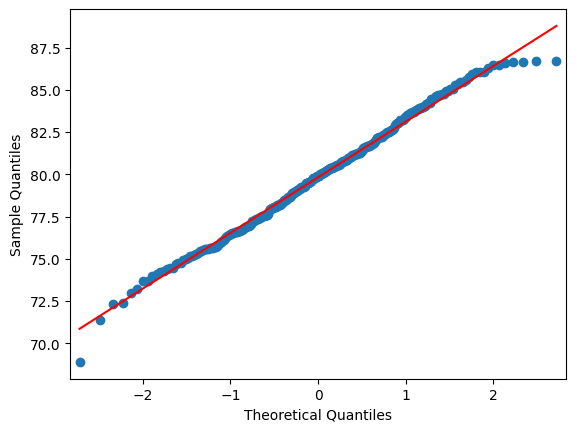

In [211]:
sm.qqplot(df['waga'] , line='s').show()

Patrząc na wykres wydaje się, jakoby waga miała rozkład normalny, pomimo widocznego lekkiego odchylenia na górze. Aby się upewnić skorzystam z testu Shapiro-Wilka testującego normalność danych z dokładnością α = 0.01.

In [212]:
print(scipy.stats.shapiro(df['waga']))

ShapiroResult(statistic=0.992904007434845, pvalue=0.15905901789665222)


Hipoteza zerowa testu twierdzi o pochodzeniu próby z populacji o rozkładzie normalnym. Z racji, że nie została ona odrzucona, to na podstawie wykresu przypuszczę, że waga ma rozkład normalny.

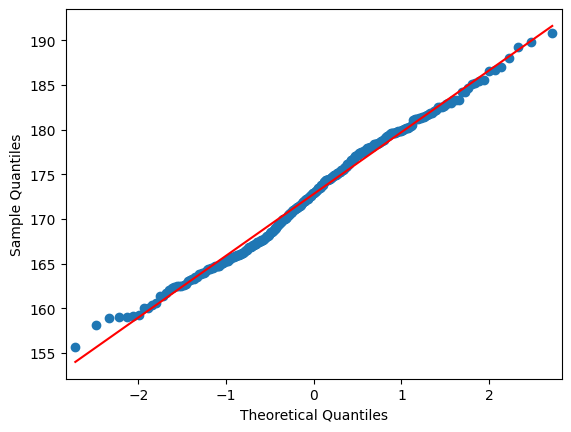

In [213]:
sm.qqplot(df['wzrost'] , line='s').show()

Wizualnie dane wyglądają jakby miały rozkład normalny. Jednakże, nie układają się one idealnie wzdłuż lini, a układają się w lekką falkę poniżej i ponad wykresem. Stąd dla zwiększenia pewności ponownie skorzystam z testu Shapiro-Wilka z dokładnością α = 0.01.

In [214]:
print(scipy.stats.shapiro(df['wzrost']))

ShapiroResult(statistic=0.989259660243988, pvalue=0.02431187406182289)


Hipoteza zerowa znów nie została odrzucona, więc również przypuszczę, że wzrost ma rozkład normalny.

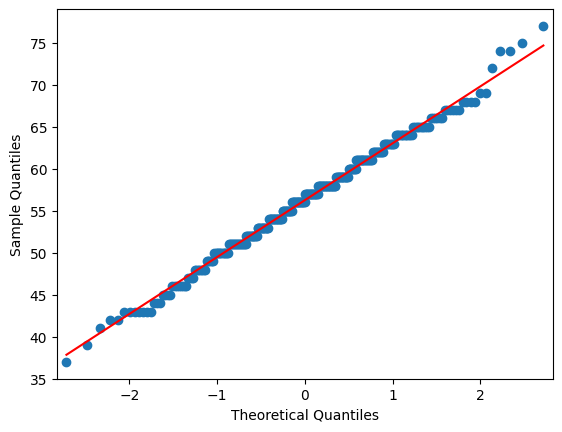

In [215]:
sm.qqplot(df['wiek'] , line='s').show()

Wykres qq dla wieku układają się dość ładnie wzdłuż linii rozkładu normalnego, lecz już z zasady skorzystam z testu Shapiro-Wilka z dokładnością α = 0.01.

In [216]:
print(scipy.stats.shapiro(df['wiek']))

ShapiroResult(statistic=0.9949511289596558, pvalue=0.42118239402770996)


Hipoteza zerowa nie została odrzucona, więc przypuszam, że wiek ma rozkład normalny.

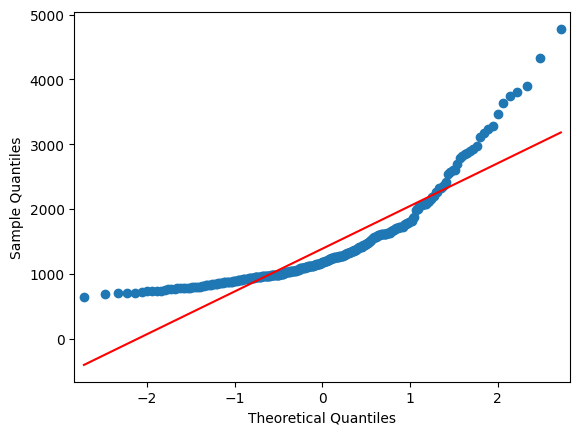

In [217]:
sm.qqplot(df['dochod'], line='s').show()

Gołym okiem widać, że nie dochód nie ma rozkładu normalnego. Natomiast można spróbować przetransformować te dane, by zaczęły mieć.

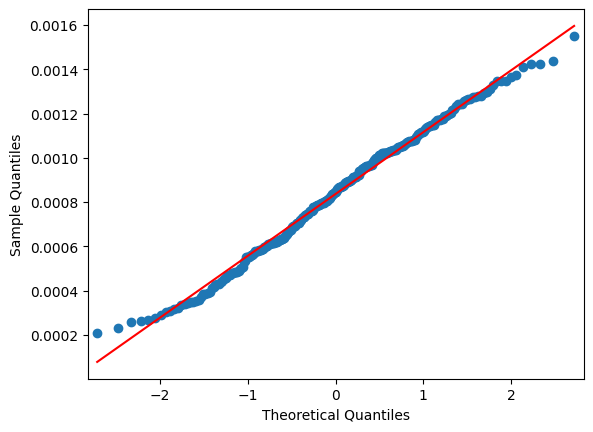

In [218]:
df['dochod_transformed'] = df['dochod'].apply(lambda x: 1/x)
sm.qqplot(df['dochod_transformed'], line='s').show()

Wygląda to o wiele lepiej. Zobaczmy jeszcze jaki będzie wynik testu Shapiro-Wilka z dokładnością α = 0.01.

In [219]:
print(scipy.stats.shapiro(df['dochod_transformed']))

ShapiroResult(statistic=0.9903587698936462, pvalue=0.04287027195096016)


Hipoteza zerowa nie została odrzucona, więc zakładam, że przetransformowany dochód ma rozkład normalny.

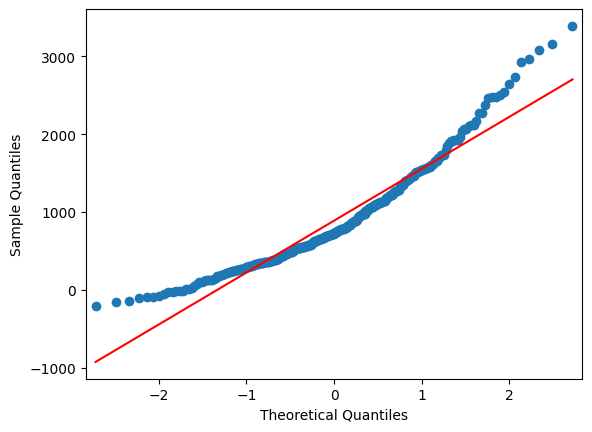

In [220]:
sm.qqplot(df['oszczednosci'], line='s').show()

W przypadku oszczędności wykres również pokazuje, że nie mają one rozkładu normalnego, jednak spróbuję je przetransformować.

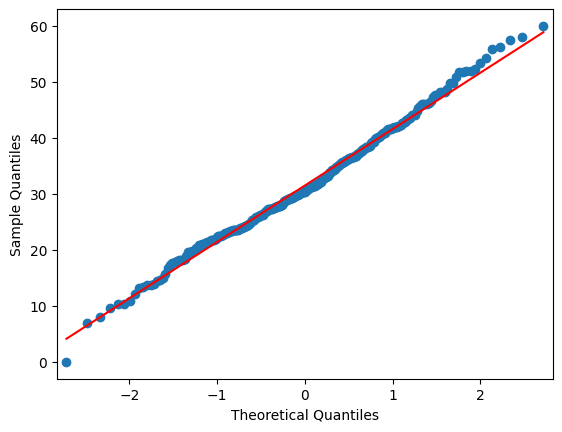

In [221]:
df['oszczednosci_transformed'] = df['oszczednosci'].apply(lambda x: np.sqrt(x + 204.24))
sm.qqplot(df['oszczednosci_transformed'], line='s').show()

In [222]:
print(scipy.stats.shapiro(df['oszczednosci_transformed']))

ShapiroResult(statistic=0.9941049814224243, pvalue=0.28678098320961)


Przetransformowane dane przypominają dość mocno rozkład normalny, a test Shapiro-Wilka nie odrzuca hipotezy, więc założę, że oszczędności przetransformowane mają rozkład normalny.

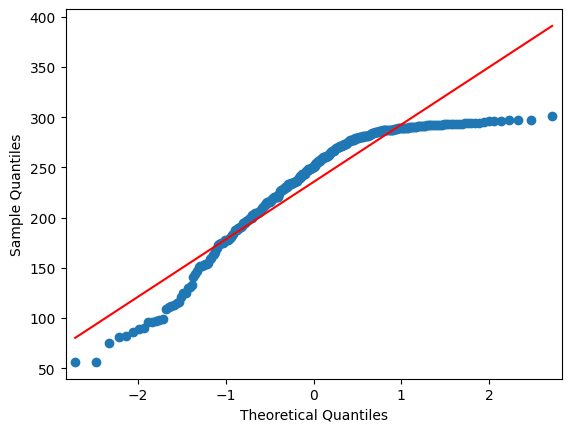

In [223]:
sm.qqplot(df['wydatki_zyw'], line='s').show()

Z wykresu widać, że wydatki nie mają rozkładu normalnego i nie udało mi sie znaleźć transformacji dla nich.

# Wykresy obrazujące rozkłady zmiennych jakościowych:

In [224]:
px.bar(df['plec'].value_counts(),
       labels={
              "plec": "Płeć",
              "value": "liczba obywateli"
              },
       title="Wykres przedstawiający płeć obywateli (1 - kobieta, 2 - mężczyzna)").show()

In [225]:
px.bar(df['dzieci'].value_counts(),
       labels={
              "value": "liczba obywateli posiadających dzieci",
              "dzieci": "liczba posiadanych dzieci"
              },
       title="Wykres przedstawiający liczbę dzieci obywateli").show()

In [226]:
px.bar(df['jednoos'].value_counts(),
       labels={
              "value": "liczba obywateli",
              "jednoos": "status gospodarstwa domowego"
              },
       title="Wykres przedstawiający status gospodarstwa domowego (0 – gospodarstwo wieloosobowe, 1 – gospodarstwo jednoosobowe").show()

In [227]:
px.bar(df['miejsce'].value_counts(),
       labels={
              "value": "liczba obywateli",
              "jednoos": "wielkość miejscowości"
              },
       title="Wykres przedstawiający wielkość miejscowości (1 – do 10 000 mieszkańców, 2 – od 10 000 mieszkańców do 100 000 mieszkańców, 3 – powyżej 100 000 mieszkańców)").show()

W wykresach zmiennych jakościowych nie widać żadnych anomali. Można założyć, że przypominają rozkład normalny.

# Sprawdzenie, czy między wartościami istnieją zależności:

### Zmienne ilościowe

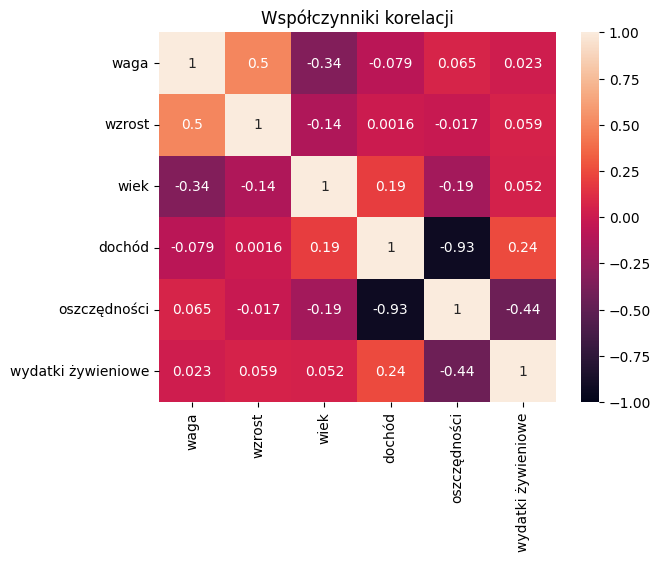

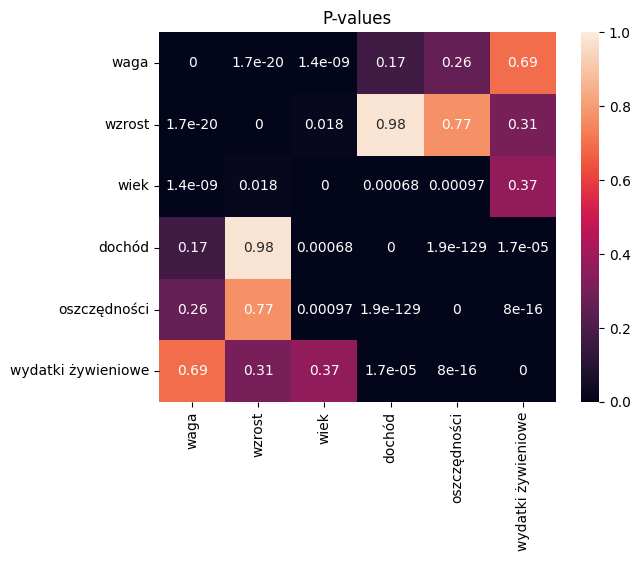

In [228]:
categories = ['waga', 'wzrost', 'wiek', 'dochod_transformed', 'oszczednosci_transformed', 'wydatki_zyw']
correlation = []
pi_vals = []
for cat in categories:
  for cat2 in categories:
    pearson = pearsonr(df[cat], df[cat2])  # Zrobienie testu oraz wyliczanie korelacji
    correlation.append(pearson[0])
    pi_vals.append(pearson[1])
sns.heatmap(np.reshape(correlation, (6,6)), annot=True, vmin=-1, vmax=1, xticklabels=['waga', 'wzrost', 'wiek', 'dochód', 'oszczędności', 'wydatki żywieniowe'], yticklabels=['waga', 'wzrost', 'wiek', 'dochód', 'oszczędności', 'wydatki żywieniowe']).set(
    title="Współczynniki korelacji")
plt.show()
sns.heatmap(np.reshape(pi_vals, (6,6)), annot=True, vmin=0, vmax=1, xticklabels=['waga', 'wzrost', 'wiek', 'dochód', 'oszczędności', 'wydatki żywieniowe'], yticklabels=['waga', 'wzrost', 'wiek', 'dochód', 'oszczędności', 'wydatki żywieniowe']).set(
    title="P-values")
plt.show()


Powyższe heatmap'y prezentują następująco:
*   Współczynniki korelacji Pearson'a dla zmiennych ilościowych
*   P-values dla powyższych współczynników


Funkcja pearsonr oprócz obliczenia współczynnika korelacji, przeprowadza również test o hipotezie zerowej "rozkłady zmiennych są normalne oraz nieskorelowane". Dla wszystkich zmiennych, oprócz wydatków żywieniowych ich rozkłady są normalne (użyte zostały przetransformowane wartości), więc w momencie odrzucenia hipotezy zerowej wiadomo, że są one skorelowane. W przypadku korelacji zmiennych z wydatkami żywieniowymi więcej może powiedzieć tylko współczynnik korelacji, lecz wciąż nie jest on koniecznie miarodajny, ponieważ warunek o rozkładzie normalnym nie jest spełniony (Można by spróbować użyc w zamian korelacji Spearman'a, jednak niżej będzie można zobaczyć wydatki żywieniowe nie są monotoniczne względem pozostałych zmiennych ilościowych).
P-values o wartości mniejszej, niż 0.01 oznaczają odrzucenie hipotezy zerowej.
Jeśli hipoteza nie zostaje odrzucona, to nie możemy odrzucić braku korelacji. Jednak patrząc na współczynniki korelacji przy zmiennych, dla których brak korelacji jest możliwy, widać że nawet gdyby istniała, to byłaby minimalna.




### Zmienne jakościowe

Aby sprawdzić zależności między parami zmiennych jakościowych wykorzystam "Chi-Square Test of Independence". Hipoteza zerowa tego testu stanowi o wzajemnej niezależności testowanych zmiennych.

Czy płeć jest zależna od ilości dzieci?

In [229]:
dfs = []
# Tworzenie tabeli krzyżowej dla płci oraz ilości dzieci.
for i in range(1, 3):
  dfs.append(df[df['plec'] == i]['dzieci'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.14012617776841182


Czy płeć jest zależna od statusu gospodarstwa domowego?

In [230]:
dfs = []
for i in range(1, 3):
  dfs.append(df[df['plec'] == i]['jednoos'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.7098649541109077


Czy płeć jest zależne od wielkości miejscowości?


In [231]:
dfs = []
for i in range(1, 3):
  dfs.append(df[df['plec'] == i]['miejsce'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.22342423171950018


Czy ilość dzieci jest zależna od statusu gospodarstwa domowego?

In [232]:
dfs = []
for i in range(0, 2):
  dfs.append(df[df['jednoos'] == i]['dzieci'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.5305427169280823


Czy ilość dzieci jest zależna od wielkości miejscowości?

In [233]:
dfs = []
for i in range(1, 4):
  dfs.append(df[df['miejsce'] == i]['dzieci'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.7162706762970519


Czy status gospodarstwa domowego jest zależny od wielkości miejscowości?

In [234]:
dfs = []
for i in range(0, 2):
  dfs.append(df[df['jednoos'] == i]['miejsce'].value_counts().sort_index())

res = chi2_contingency(dfs)
print("P-value:", res.pvalue)

P-value: 0.7695667530897057


We wszystkich przypadkach wartość p-value była niemało większa od od 0.05, więc nie ma podstawy do odrzucenia hipotezy, jakoby zmienne były niezależne.

# Wykresy podsumowujące powyższe dane:

## Relacje zmiennych ilościowych z wydatkami


Poniższe wykresy są robione na nieprzetransfomowanych danych, aby dało się je przystępnie interpretować.

In [235]:
columns = ['waga', 'wzrost', 'wiek', 'dochod', 'oszczednosci']
col_names = ['waga', 'wzrost', 'wiek', 'dochód', 'oszczędności']
col_titles = ['wagi', 'wzrostu', 'wieku', 'miesięcznego dochodu', 'miesięcznych oszczędności']
for i in range(len(columns)):
  px.scatter(pd.concat([df['wydatki_zyw'], df[columns[i]]]), x=df[columns[i]], y=df['wydatki_zyw'], labels={'x':col_names[i], 'y':'wydatki'}, title = "Wydatki na jedzenie względem " + col_titles[i]).show()

Z powyższych wykresów widać, że wydatki nie są bezpośrednio zależne od wagi, wzrostu, wieku, czy dochodu. Dla trzech pierwszych zmiennych jest to wynik dość spodziewany. Natomiast ciekawy jest fakt, że przy większych dochodach, obywatele wcale nie wydają więcej, a w dodatku wiele osób o niskich dochodach wydaje najwięcej. Może być to częściowo spowodowane faktem, iż większość badanych ma dochód mniejszy, niż 1500, czy 2000. Gdybyśmy w próbie trafili obywateli z bardziej różnorodnymi dochodami, to mógłby się uwidocznić inny trend. Patrząc na wykres pod kątem oszczędności widać, że większość społeczeństwa mająca spore miesięczne wydatki nie jest w stanie zaoszczędzić dużo pieniędzy (Zapewne głównie to są osoby z poprzedniego wykresu, mające nieduże przychody, a jedne z największych wydatków).

### Co z pieniędzmi, które zostały po wydatkach żywieniowych?

In [236]:
other = df.copy()

other['inne'] = other['dochod'] - other['wydatki_zyw']
px.scatter(other, x=other['oszczednosci'], y=other['inne'], labels={'x':"dochód", 'y':'Wydatki inne'}, trendline="ols", title = "Pozostała pensja względem miesięcznych oszczędności").show()

other = other[other['dochod'] < 2500]
px.scatter(other, x=other['oszczednosci'], y=other['inne'], labels={'x':"dochód", 'y':'Wydatki inne'}, trendline="ols", title = "Pozostała pensja względem miesięcznych oszczędności (Przybliżenie na wielkość pensji < 2500))").show()

Widać, że mieszkańcy Bajtocji miesięcznie odkładają oszczędności w miarę liniowo względem bajtolarów, które im zostały po wydatkach na jedzenie.

## Dochód względem wielkości zamieszkiwanej miejscowości.

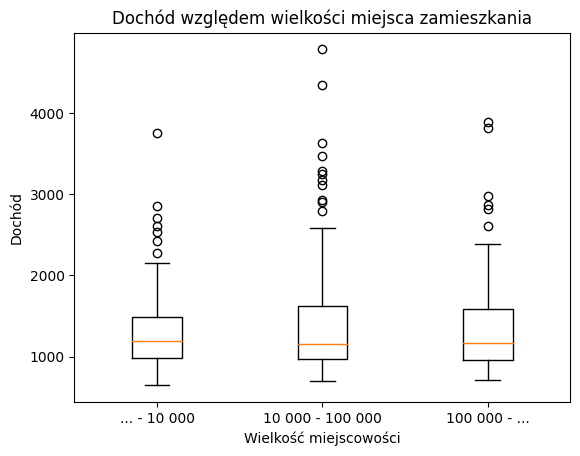

In [237]:
data_1 = df[df['miejsce'] == 1]['dochod']
data_2 = df[df['miejsce'] == 2]['dochod']
data_3 = df[df['miejsce'] == 3]['dochod']
data_plot = [data_1, data_2, data_3]

plt.boxplot(data_plot, labels=['... - 10 000', '10 000 - 100 000', '100 000 - ...'])
plt.title('Dochód względem wielkości miejsca zamieszkania')
plt.xlabel('Wielkość miejscowości')
plt.ylabel('Dochód')
plt.show()

Widać, że średnio 50% społeczeństwa w miejscowości o każdej wielkości zarabia podobne kwoty oscylujące między 1000-1500 bajtalarami. W mniejszych miejscowościach kwoty te są bardziej zbliżone, niż w większych. W miejscowościach o dużej oraz zwłaszcza średniej wielkości lepiej zarabiające 50% społeczeństwa zarabia więcej, niż w małych miejscowościach.  W większych miejscowościach też jest więcej obywateli, więc rozpiętość zarobków oraz ilość ludzi, którzy wychodzą poza normy zarabiając dużo większe kwoty, niż reszta społeczeństwa, co ma sens, bo jednak mieszka w nich najwięcej osób.

## Płeć respondenta względem faktu prowadzenia jednoosobowego gospodarstwa.

In [238]:
solo = df[df['jednoos'] == 1]['plec'].value_counts()
other = df[df['jednoos'] == 0]['plec'].value_counts()
bar = pd.DataFrame({"płeć": ["Kobiety", "Mężczyźni", "Kobiety", "Mężczyźni"], "Liczba obywateli": [solo[1], solo[2], other[1], other[2]] ,"status": ["Samotnie", "Samotnie", "Z kimś", "Z kimś"]})
fig = px.bar(bar, x="płeć", y="Liczba obywateli", color="status", title="Płeć względem jednoosobowego gospodarstwa")
fig.show()

Powyższy wykres jest kolejnym czynnikiem skłaniającym do przyjęcia tezy, iż płeć obywatela jest niezależna od faktu, czy mieszka samotnie. Nie dość, że wynik testu chi-square nie pozwala nam wykluczyć niezależności, to stosunek statusów mieszkania samotnie kobiet oraz mężczyzn różni się niewiele. Należałoby znaleźć jeszcze jakiś czynnik, który pomoże sprawdzić wypływ na powyższe zjawisko. Wiek wydawałby się ciekawym pomysłem, jednak wszyscy ankietowani są w wieku średnim/starszym, więc wynik byłby niemiarodajny. Spróbujmy zobaczyć, czy wielkość zamieszkiwanej miascowości wpłynie na wyniki:

In [239]:
titles = [' (Małe miasta)', ' (Średnie miasta)', ' (Duże miasta)']
for i in range(1, 4):
  sms = df[df['miejsce'] == i]
  solo = sms[sms['jednoos'] == 1]['plec'].value_counts()
  other = sms[sms['jednoos'] == 0]['plec'].value_counts()
  bar = pd.DataFrame({"płeć": ["Kobiety", "Mężczyźni", "Kobiety", "Mężczyźni"], "Liczba obywateli": [solo[1], solo[2], other[1], other[2]] ,"status": ["Samotnie", "Samotnie", "Z kimś", "Z kimś"]})
  fig = px.bar(bar, x="płeć", y="Liczba obywateli", color="status", title="Płeć względem jednoosobowego gospodarstwa" + titles[i - 1])
  fig.show()

Gołym okiem widać, że stosunki wciąż zostają podobnej wielkości. Prowadzi to więc do konkluzji, że zarówno kobiety jak i mężczyźni niezależnie decydują się na mieszkanie samemu lub z innymi osobami.

# Przedziały ufności wieku

### Średnia


Dane na temat wieku mają rozkład normalny, a średnia oraz odchylenie standardowe są nieznane i próbka danych jest reprezentatywna, więc bez żadnych przeszkód mogę skorzystać z poniższego wzoru na przedziały ufności średniej i odchylenia standardowego.

In [240]:
# Dane ze zbioru
age_data = df['wiek']
alfa = 0.01
N = age_data.count()
mean = age_data.mean()

# Obliczanie przedziałów średniej
std = 0
for age in age_data:
  std += pow((age - mean), 2)
std = np.sqrt(std / (N-1))
t_student = t.ppf(1 - alfa/2, N-1)
error = t_student * std / np.sqrt(N)
print("Przedział ufności dla średniej wieku: (" + str(mean - error) + ", " + str(mean + error) + ")")

Przedział ufności dla średniej wieku: (55.25152156054645, 57.26821528155881)


### Odchylenie standardowe

In [241]:
std = age_data.std()

# Obliczanie przedziałów odchylenia standardowego
chi_low = scipy.stats.chi2.isf(alfa/2, df=N-1)
chi_upp = scipy.stats.chi2.isf(1-alfa/2, df=N-1)

low_bound = np.sqrt((N-1) * pow(std, 2) / chi_low)
upp_bound = np.sqrt((N-1) * pow(std, 2) / chi_upp)
print("Przedział ufności dla odchylenia standardowego wieku: (" + str(low_bound) + ", " + str(upp_bound) + ")")

Przedział ufności dla odchylenia standardowego wieku: (6.136394836972781, 7.568207600724594)


### Kwartyle

Kolejne kwartyle policzę za pomocą bootstrap'ingu. Przy boostrap'ingu nie są wymagane założenia związane z rozkładem, ani znaniem wartości poszczególnych statystyk.

In [285]:
def quar1(samp):  # Oblicza wartość pierwszego kwartylu dla danych zawartych w 'samp'.
  return np.quantile(samp, 0.25)

def quar2(samp):  # Oblicza wartość drugiego kwartylu dla danych zawartych w 'samp'.
  return np.quantile(samp, 0.50)

def quar3(samp):  # Oblicza wartość trzeciego kwartylu dla danych zawartych w 'samp'.
  return np.quantile(samp, 0.75)

quartiles = [quar1, quar2, quar3]
quar_names = ['pierwszego', 'drugiego', 'trzeciego']
for i in range(3):
    boot = scipy.stats.bootstrap([age_data,], quartiles[i], confidence_level=0.99, n_resamples=1000, method='percentile')
    print("Przedział ufności dla " + quar_names[i] + " kwartylu: (" + str(boot.confidence_interval.low) + ", " + str(boot.confidence_interval.high) + ")")

Przedział ufności dla pierwszego kwartylu: (51.0, 53.0)
Przedział ufności dla drugiego kwartylu: (55.0, 58.0)
Przedział ufności dla trzeciego kwartylu: (59.0, 62.0)


# Podział społeczeństwa względem dochodów


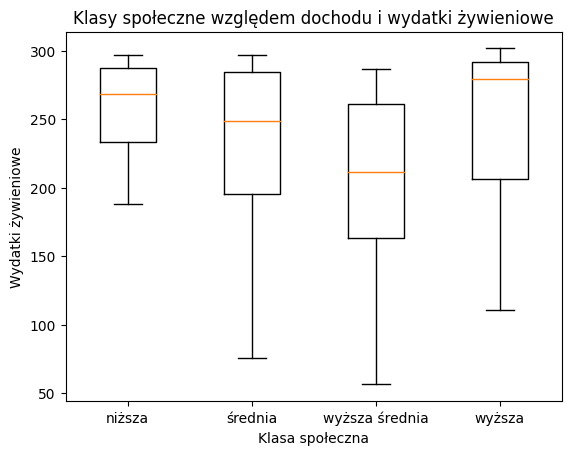

In [243]:
group1 = df[df['dochod'] < np.quantile(df['dochod'], .25)]          # Klasa niższa
group2 = df[np.quantile(df['dochod'], .25) <= df['dochod']]         # Klasa średnia
group2 = group2[group2['dochod'] < np.quantile(df['dochod'], .75)]
group3 = df[np.quantile(df['dochod'], .75) <= df['dochod']]         # Klasa wyższa średnia
group3 = group3[group3['dochod'] < np.quantile(df['dochod'], .90)]
group4 = df[df['dochod'] >= np.quantile(df['dochod'], .90)]         # Klasa wyższa


plt.boxplot([group1['wydatki_zyw'], group2['wydatki_zyw'], group3['wydatki_zyw'], group4['wydatki_zyw']], labels=['niższa', 'średnia', 'wyższa średnia', 'wyższa'])
plt.title('Klasy społeczne względem dochodu i wydatki żywieniowe')
plt.xlabel('Klasa społeczna')
plt.ylabel('Wydatki żywieniowe')
plt.show()


Z powyższego wykresu da się wyczytać, iż wydatki żywieniowe grupy 1 (Klasa niższa) są tak naprawdę najwyższe.
Może być to bardzo zadziwijające, ponieważ ma ona najmniejszy średni dochód spośród wszystkich:

In [244]:
print("Średni dochód klasy niższej: " + str(group1['dochod'].mean()))
print("Średni dochód klasy średniej: " + str(group2['dochod'].mean()))
print("Średni dochód klasy wyższej średniej: " + str(group3['dochod'].mean()))
print("Średni dochód klasy wyższej: " + str(group4['dochod'].mean()))
print("Średnie wydatki na żywność klasy niższej: " + str(group1['wydatki_zyw'].mean()) + ", odchylenie standardowe: " + str(group1['wydatki_zyw'].std()))
print("Średnie wydatki na żywność klasy średniej: " + str(group2['wydatki_zyw'].mean()) + ", odchylenie standardowe: " + str(group2['wydatki_zyw'].std()))
print("Średnie wydatki na żywność klasy wyższej średniej: " + str(group3['wydatki_zyw'].mean()) + ", odchylenie standardowe: " + str(group3['wydatki_zyw'].std()))
print("Średnie wydatki na żywność klasy wyższej: " + str(group4['wydatki_zyw'].mean()) + ", odchylenie standardowe: " + str(group4['wydatki_zyw'].std()))

Średni dochód klasy niższej: 851.1140789473684
Średni dochód klasy średniej: 1209.2458552631579
Średni dochód klasy wyższej średniej: 1814.8413333333338
Średni dochód klasy wyższej: 2974.002580645161
Średnie wydatki na żywność klasy niższej: 258.6101315789473, odchylenie standardowe: 31.333049239566883
Średnie wydatki na żywność klasy średniej: 231.22664473684208, odchylenie standardowe: 59.34493065652634
Średnie wydatki na żywność klasy wyższej średniej: 201.49044444444448, odchylenie standardowe: 65.86981450888065
Średnie wydatki na żywność klasy wyższej: 249.86258064516127, odchylenie standardowe: 56.083263039148136


Jak to możliwe, że chociażby klasa niższa wydaje średnio więcej na jedzenie (prawie 1/3 swoich średnich zarobków), niż klasa wyższa, która zarabia średnio ponad 4 razy więcej bajtalarów? Po bardziej wynikliwej analizie prawdopodobna przyczyna prezentuje się następująco:

In [245]:
print("Wszyscy ankietowani obywatele klasy niższej: " + str(group1['jednoos'].count()) + ", Ci z nich, którzy mieszkają samotnie: " + str(group1['jednoos'].sum()))
print("Wszyscy ankietowani obywatele klasy średniej: " + str(group2['jednoos'].count()) + ", Ci z nich, którzy mieszkają samotnie: " + str(group2['jednoos'].sum()))
print("Wszyscy ankietowani obywatele klasy średniej wyższej: " + str(group3['jednoos'].count()) + ", Ci z nich, którzy mieszkają samotnie: " + str(group3['jednoos'].sum()))
print("Wszyscy ankietowani obywatele klasy wyższej " + str(group4['jednoos'].count()) + ", Ci z nich, którzy mieszkają samotnie: " + str(group4['jednoos'].sum()))

Wszyscy ankietowani obywatele klasy niższej: 76, Ci z nich, którzy mieszkają samotnie: 0
Wszyscy ankietowani obywatele klasy średniej: 152, Ci z nich, którzy mieszkają samotnie: 51
Wszyscy ankietowani obywatele klasy średniej wyższej: 45, Ci z nich, którzy mieszkają samotnie: 45
Wszyscy ankietowani obywatele klasy wyższej 31, Ci z nich, którzy mieszkają samotnie: 31


Wszyscy obywatele z klasy niższej oraz część z klasy średniej może mieć dość mocno zawyżone wydatki przez kupowanie jedzenia dla całego gospodarstwa, a nie tylko dla siebie. Odchylenie standardowe w klasie niższej też jest najmniejsze, co może być spowodowane tym, że obywatele kupują do gospodarstw domowych w miarę stałą ilość podobnego jedzenia, tak aby wystarczało na pozostałe wydatki. W klasie średniej odchylenie jest większe, ponieważ jednak jest to klasa największa i tym samym najbardziej różnorodna, bo niektórzy też mieszkają tam sami, a niektórzy nie oraz rozpiętość dochodów jest największa. Tymczasem osoby z klasy wyższej średniej kupują jedzenie wyłącznie sobie, przez co ich wydatki są mniejsze. Jednak odchylenie standardowe jest dość duże, ponieważ część woli przeznaczać pieniądze niekoniecznie na jedzenie. Niemałe dochody oraz samotne mieszkanie pozwala na zróżnicowane tryby życia wewnątrz klasy. Obywatele z klasy wyższej natomiast są w stanie pozwolić sobie na droższe, czy bardziej jakościowe posiłki, więc pomimo mieszkania samotnie średnio wydają dużo pieniędzy. Jednak nawet w klasie wyższej widać rozstrzał, bo wciąż niekoniecznie każdy z niej chce przeznaczać dużo bajtalarów na wyżywienie.



# Testy hipotez

## Czy kobiety cechują się wyższymi wartościami oszczędności, niż mężczyźni?

Aby sprawdzić powyższą hipotezę użyję jednego z testów 'Two Sample T-Test' lub 'Welch test' (jeśli wariancje są różne), które sprawdzają, stosunek średnich wartości nieznanych populacji względem siebie. Najpierw jednak należy sprawdzić, czy wariancje tych dwóch próbek są takie same. W tym celu wykonam 'F-Test'. Przetransformowane dane związane z oszczędnościami mają rozkład normalny, więc mogę skorzystać z wyżej wymienionych testów. (Wszystkie testy wykonywane są z dokładnością α = 0.01)

In [246]:
f = df[df['plec'] == 1]['oszczednosci_transformed']  # Kobiety
m = df[df['plec'] == 2]['oszczednosci_transformed']  # Mężczyźni

f_stat = np.var(f, ddof=1) / np.var(m, ddof=1)
p_value = 1 - scipy.stats.f.cdf(f_stat, f.count() - 1, m.count() - 1)
print("Wartość f-statystki: " + str(f_stat) + ", p-value: " + str(p_value) + ".")

Wartość f-statystki: 1.2662332955578222, p-value: 0.07574179527834024.


Hipoteza zerowa f-testu twierdzi, że wariancje próbek są równe. A z racji, że p-value jest większe, niż 0.01, to nie możemy odrzucić tej hipotezy. Skoro f-test nie dał jasnego werdyktu, to skorzystam z obu testów, jednak najpierw z 'Two Sample T-Test, który ma założenie, że wariancje są równe.

In [247]:
print("P-value testu z hipotezą zerową, twierdzącą, że kobiety mają mniejsze lub takie same oszczędności, jak mężczyźni: " + str(ttest_ind(f, m, alternative="greater").pvalue))
print("P-value testu z hipotezą zerową, twierdzącą, że kobiety mają większe lub takie same oszczędności, jak mężczyźni:  " + str(ttest_ind(f, m, alternative="less").pvalue))
print("P-value testu: z hipotezą zerową, twierdzącą, że kobiety mają takie same oszczędności, jak mężczyźni: " + str(ttest_ind(f, m, alternative="two-sided").pvalue))

P-value testu z hipotezą zerową, twierdzącą, że kobiety mają mniejsze lub takie same oszczędności, jak mężczyźni: 0.4494295946912632
P-value testu z hipotezą zerową, twierdzącą, że kobiety mają większe lub takie same oszczędności, jak mężczyźni:  0.5505704053087368
P-value testu: z hipotezą zerową, twierdzącą, że kobiety mają takie same oszczędności, jak mężczyźni: 0.8988591893825264


Z racji nie udało się odrzucić żadnej z trzech hipotez zerowych, to ciężko określić, czy kobiety mają większe oszczędności. Możemy spróbować skorzystać jeszcze z testu Welch'a, który nie zakłada równych wariancji.

In [248]:
print("P-value testu z hipotezą zerową, twierdzącą, że kobiety mają mniejsze lub takie same oszczędności, jak mężczyźni: " + str(ttest_ind(f, m, alternative="greater", equal_var = False).pvalue))
print("P-value testu z hipotezą zerową, twierdzącą, że kobiety mają większe lub takie same oszczędności, jak mężczyźni:  " + str(ttest_ind(f, m, alternative="less", equal_var = False).pvalue))
print("P-value testu: z hipotezą zerową, twierdzącą, że kobiety mają takie same oszczędności, jak mężczyźni: " + str(ttest_ind(f, m, alternative="two-sided", equal_var = False).pvalue))

P-value testu z hipotezą zerową, twierdzącą, że kobiety mają mniejsze lub takie same oszczędności, jak mężczyźni: 0.4489987937886144
P-value testu z hipotezą zerową, twierdzącą, że kobiety mają większe lub takie same oszczędności, jak mężczyźni:  0.5510012062113855
P-value testu: z hipotezą zerową, twierdzącą, że kobiety mają takie same oszczędności, jak mężczyźni: 0.8979975875772288


Niestety ten test również nie pozwolił nam odrzucić żadnej hipotezy zerowej, więc nie jesteśmy w stanie określić, czy kobiety cechują się wyższymi oszczędnościami, niż mężczyźni.

## Czy niższa proporcja wydatków na żywność względem dochodu jest skorelowana z wyższymi oszczędnościami?

Sprawdźmy czy proporcja wydatków żywieniowych do dochodu ma rozkład normalny za pomocą testu Shapiro-Wilka.

In [249]:
print("P-value testu: " + str(scipy.stats.shapiro(df["wydatki_zyw"]/df['dochod']).pvalue))

P-value testu: 6.942413165234029e-05


Niestety hipoteza jakoby proporcja zmiennych miała rozkład normalny została odrzucona, więc nie można skorzystać z korelacji Pearson'a. Możemy natomiast sprawdzić, czy proporcja jest związana monotonicznie z oszczędnościami.

In [250]:
px.scatter(df, x=(df["wydatki_zyw"]/df['dochod']), y = df['oszczednosci'])


Jesteśmy w stanie powiedzieć, że wartość oszczędności maleje, gdy stosunek wydatków żywienia i dochodu rośnie, co oznacza, że prawdopodobnie jest pomiędzy nimi relacja monotoniczności. Dzięki temu można skorzystać z korelacji Spearman'a.

In [251]:
res = scipy.stats.spearmanr(df["wydatki_zyw"]/df['dochod'], b=df['oszczednosci'], alternative='two-sided')
print("Wartości korelacji: " + str(res.statistic) + ", P-value: " + str(res.pvalue))

Wartości korelacji: -0.9726091116445553, P-value: 2.0103756749114015e-193


P-value mniejsze od α pozwala nam odrzucić hipotezę zerową, jakoby nie było korelacji pomiędzy zmiennymi. Stąd przyjmujemy hipotezę alternatywną, twierdzącą, że proporcja wydatków na żywność względem dochodu jest skorelowana z oszczędnościami.

## Czy średnia waga kobiet jest wyższa, niż 56kg?

Aby sprawdzić powyższą hipotezę użyję T-Test'u. Jednak najpierw należy sprawdzić, czy waga kobiet ma rozkład normalny.

In [252]:
waga_kobiet = df[df['plec'] == 1]['waga']
print("P-value testu: " + str(scipy.stats.shapiro(waga_kobiet).pvalue))

P-value testu: 0.6817423105239868


Test Shapiro-Wilka nie pozwala nam odrzucić hipotezy, że rozkład jest normalny, więc założę, że zmienna ma rozkład normalny. Hipoteza zerowa t-testu twierdzi, że średnia waga kobiet jest mniejsza lub równa 56kg.

In [253]:
print("P-value testu: " + str(ttest_1samp(df[df['plec'] == 1]['waga'], 56, alternative="greater").pvalue))

P-value testu: 1.5711163348630752e-152


P-value testu jest mniejsze, niż α stąd hipoteza zerowa, jakoby kobiety średnio ważyły mniej lub dokładnie 56 kg zostaje odrzucona. Przyjmujemy hipotezę alternatywną, twierdzącą, że średnia waga kobiet jest wyższa, niż 56kg.

## Czy zmienna dochód ma rozkład wykładniczy?

Spójrzmy na histogram przedstawiający dane związane z dochodem.

In [254]:
px.histogram(df['dochod']).show()

Na pierwszy rzut oka przypomina on dość mocno rozkład wykładniczy (poza małym spadkiem na początku). Aby zbadać, czy hipoteza powyższa jest prawdziwa, skorzystam z testu Lilliefors'a, który jest testem bazowanym na Kolmogorov–Smirnov. Test Kolmogorov–Smirnov zakłada, że porównywany rozkład jest rozkładem ciągłym, co jest spełnione przez rozkład wykładniczy. Test Lillieforse'a sam estymuje parametry rozkładu, więc nie trzeba samemu ich podawać. Hipoteza zerowa zakłada, że dane mają rozkład wykładniczy, a hipoteza alternatywna, że dane nie mają rozkładu wykładniczego.

In [255]:
stat, pval = statsmodels.stats.diagnostic.kstest_exponential(df['dochod'], dist='exp', pvalmethod='table')
print("Wartość statystki: " + str(stat) + ", wartość P-value: " + str(pval))

Wartość statystki: 0.39091815012653996, wartość P-value: 0.0009999999999998899


Niestety pvalue < α, więc hipoteza zerowa została odrzucona, co oznacza, że przyjęta zostaje hipoteza alternatywna.

# Badanie na temat wysokości wydatków na żywność

Przy tworzeniu poniższego modelu powróciłem do pierwotnych danych oraz usunąłem 6 badanych, z nieprawidłowymi wartościami (Tych samych, których na początku raportu). Poniżej również rozkodowuję zmienne jakościowe.

In [256]:
# Reset danych + get_dummies
df_model = pd.read_csv('dane_projekt1.csv', sep = ";", index_col='id').sort_values('id')
indexes_to_drop = df_model.loc[df_model['wydatki_zyw'] < 0].index
df_model.drop(labels=indexes_to_drop, axis=0, inplace=True)
df_model = pd.concat([df_model, pd.get_dummies(df_model['dzieci'], drop_first=True, dtype=int).rename(columns=lambda x:'dzieci_' + str(x))], axis=1)
df_model = df_model.drop('dzieci', axis=1)
df_model = pd.concat([df_model, pd.get_dummies(df_model['miejsce'], drop_first=True, dtype=int).rename(columns=lambda x:'miejsce_' + str(x))], axis=1)
df_model = df_model.drop('miejsce', axis=1)
df_model = pd.concat([df_model, pd.get_dummies(df_model['plec'], drop_first=True, dtype=int).rename(columns=lambda x:'mężczyzna')], axis=1)
df_model = df_model.drop('plec', axis=1)

# Dodawanie stałej
df_model = sm.add_constant(df_model)

# Podział na zmienne objaśniające i objaśniane.
ans = df_model['wydatki_zyw']
df_model = df_model.drop('wydatki_zyw', axis=1)

# Model
model = sm.OLS(ans, df_model)
results = model.fit()
fit_val = results.fittedvalues
resids = results.resid

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     44.03
Date:                Thu, 09 May 2024   Prob (F-statistic):           3.21e-63
Time:                        15:58:11   Log-Likelihood:                -1487.6
No. Observations:                 304   AIC:                             3005.
Df Residuals:                     289   BIC:                             3061.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          227.4157     92.452      2.460   

Powyższy model charakteryzuje się dość sporym $R^2$, co oznacza, że teorytycznie 68.1% wariancji w modelu opisującym wydatki żywieniowe jest wytłumaczone przez podane zmienne. Jednak wartość $R^2$ mogła częściowo się podnieść ze względu na ilość danych, a niekoniecznie ich przydatność (overfitting).
Można również zauważyć, że wartość Prob (F-statistic) jest mniejsza od 0.01, co oznacza, że hipoteza zerowa, jakoby wszystkie zmienne wspólnie były nieważne, jest odrzucana. Natomiast w kwestii testów istotności indywidualnej zmiennych jesteśmy w stanie powiedzieć, że hipoteza jakoby zmienna byłaby indywidualnie nieistotna została odrzucona dla dochodów i oszczędności. W pozostałych przypadkach nie wiadomo, czy zmienne są indywidualnie istotne.   

## Sprawdzenie założeń KMRL

Założenia KMRL to:


*   Liniowość
*   Residuua mające rozkład normalny
*   Homoskedastyczność
*   Brak autokorelacji




### Liniowość

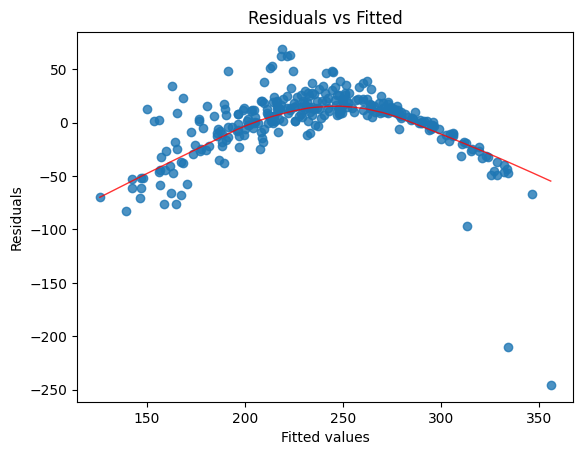

In [257]:
linear = plt.figure()
linear.axes[0] = sns.regplot(x=fit_val, y=resids,
                                scatter=True,
                                ci=False,
                                lowess=True,
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
linear.axes[0].set_title('Residuals vs Fitted')
linear.axes[0].set_xlabel('Fitted values')
linear.axes[0].set_ylabel('Residuals');
linear.show()

Liniowość niestety nie jest spełnionym kryterium w naszym modelu. Większość wartości na wykresie układa się w chmurę bez zauważalnego trendu wokół linii. Jednak jest kilka obserwacji mocno oddalonych, o bardzo niskiej wartości residuum. Są to obserwacje odstające zaburzające liniowość.

### Rozkład residuów

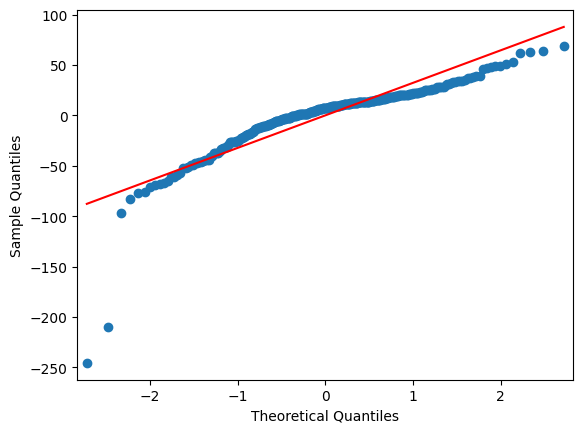

In [258]:
sm.qqplot(resids, line='s').show()

Gołym okiem widać, że rozkład residuów nie jest rozkładem normalnym. Ponownie widać istnienie obserwacji odstających, ale pozostałe dane też nie do końca układają się wzdłuż linii.

### Homoskedastyczność i brak autokorelacji

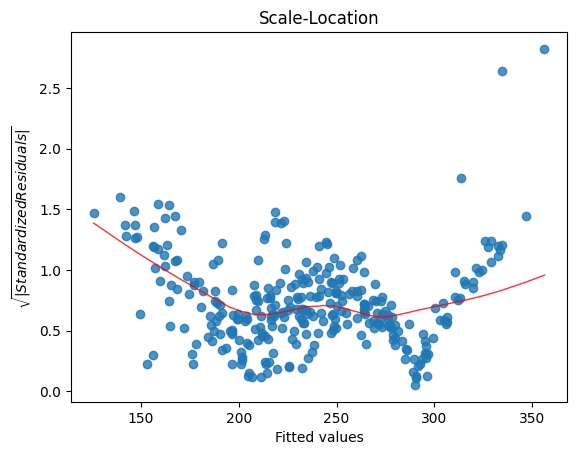

In [259]:
homoscedasticity = plt.figure()
sns.regplot(x=fit_val, y=np.sqrt(np.abs(results.get_influence().resid_studentized_internal)),
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
homoscedasticity.axes[0].set_title('Scale-Location')
homoscedasticity.axes[0].set_xlabel('Fitted values')
homoscedasticity.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
homoscedasticity.show()

Na powyższym wykresie widać, że oprócz ponownych odstających obserwacji, istnieje też trend. Wartości układają się w kształt literki 'W', zamiast układać się w miarę równomierną chmurę. Te dwa spostrzeżenia stanowią o braku homoskedastyczności.

In [260]:
auto = px.line(y=resids, labels={"y": "Residuals", "x": "Number of observation"}, title="Residuals vs number of observation")
auto.add_hline(y=0, line_color="black")
auto.show()

Z kolei na wykresie dotyczącym residuów oraz ilości obserwacji widać wzrost amplitudy, co potwierdza tezę o braku homoskedastyczności. Możliwy jest również brak autokorelacji, ponieważ wartości nie do końca oscylują wokół linii, a dość odbiegają (nie licząc obserwacji odstających, w których przypadku odbieganie jest oczywiste).

### Dodatkowo: Obserwaje wpływowe

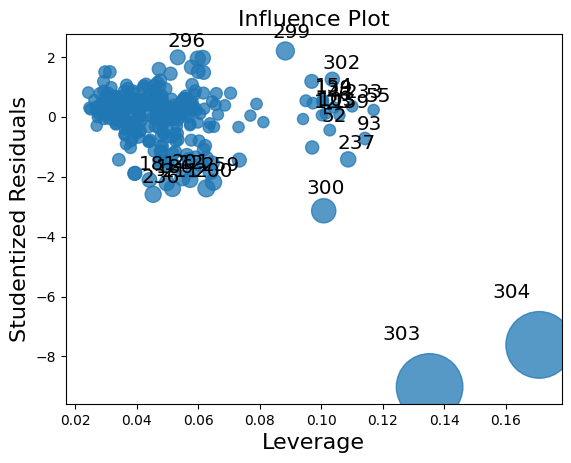

In [261]:
sm.graphics.influence_plot(results, criterion="cooks").show()

Powyższy wykres ukazje dużą ilość obserwacji odstających, które psują mocno nasz model. Już na początku, przy analizie wstępnej danych udało się usunąć 6 zmiennych z błędnymi danymi. Na powyższym influence plot'cie widać, że obserwacje 303 oraz 304 mocno odstają od reszty. Nie charakteryzują się one błędnymi wartościami, więc póki co je zostawię, ponieważ przy następnych zmianach w modelu mogą one zostać wyeliminowane.

### Niedokładna współliniowość

Jednym sposobem na kontrolowanie współliniowości jest policzenie współczynnika VIF dla zmiennych w modelu.

In [262]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_model.columns
vif_data["VIF"] = [variance_inflation_factor(df_model.values, i) for i in range(len(df_model.columns))]
print(vif_data)

         feature          VIF
0          const  2370.369775
1           waga     1.769253
2         wzrost     2.264761
3           wiek     1.231153
4         dochod     9.285948
5   oszczednosci    11.379335
6        jednoos     2.455901
7       dzieci_1     2.402073
8       dzieci_2     2.299309
9       dzieci_3     2.059002
10      dzieci_4     1.732802
11      dzieci_5     1.307342
12     miejsce_2     1.514154
13     miejsce_3     1.508737
14     mężczyzna     2.668233


Współczynnik VIF wyszedł dość wysoki dla oszczędności oraz dochodu. Oznacza to, że pozostałe zmienne w dużym stopniu objaśniają oszczędności oraz dochód (Możliwe, że one też objaśniają siebie nawzajem). Stąd problem niedokładnej wspóliniowości występuje w naszym modelu.

Już wcześniej uwidoczniła się bardzo duża wartość korelacji między dochodem oraz oszczędnościami, a teraz do tego współliniowość. Usunięcie tych zmiennych niekoniecznie byłoby najlepszy posunięciem, ponieważ mogą one wyjaśniać siebie nawzajem, ale też każda z osobna sama w sobie zawiera wiele informacji. Poza tym tabelka z wynikami wytrenowanego modelu wskazywała, iż obie zmienne są istotne indywidualnie. Skoro nie można ich usunąć, a wpływają mocno na siebie nawzajem, to spróbujmy je połączyć. Weźmy wykres ich różnicy wraz z wydatkami na żywność.

In [263]:
px.scatter(x=df_model["dochod"] - df_model["oszczednosci"], y=ans, labels={"x": "Różnica dochodu i oszczędności", "y":"Wydatki żywieniowe"})

Wykres przypomina odwróconą parabolę. Stąd można spróbować zaminić zmienne dochód i oszczędności na kolejne potęgi wielomianu drugiego stopnia o zmiennej będącej różnicą tych dochodu oraz oszczędności. Skopiujmy więc model i wprowadźmy zmiany w życie.

In [264]:
df_model_2 = df_model.copy()
ans_2 = ans.copy()
df_model_2["stosunek"] =  df_model_2['dochod'] - df_model_2['oszczednosci']
df_model_2["stosunek_squared"] = (df_model_2['dochod'] - df_model_2['oszczednosci'])**2
df_model_2.drop(labels = ["dochod", "oszczednosci"], axis=1, inplace=True)

In [265]:
model = sm.OLS(ans_2, df_model_2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.122e+04
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        15:58:13   Log-Likelihood:                -445.90
No. Observations:                 304   AIC:                             921.8
Df Residuals:                     289   BIC:                             977.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3587      3.027  

$R^2$ wzrosło, aż do 1. Wygląda to bardzo dobrze, jednak model da się jeszcze polepszyć, chociażby przez usunięcie nieistotnych zmiennych. Będę kolejno odrzucał wszystkie zmienne o najwyższym p-value, póki nie zostaną same zmienne indywidualnie istotne, czyli takie posiadające p-value mniejsze od α = 0.01 (nie wliczając stałej).

In [266]:
res = results.pvalues.drop(labels=["const"])

while (res.max() > 0.01):
  max_ind = res[res == res.max()].index
  df_model_2.drop(labels = max_ind, axis=1, inplace=True)
  model_2 = sm.OLS(ans_2, df_model_2)
  results = model_2.fit()
  res = results.pvalues.drop(labels=["const"])

print(results.summary())
fit_val = results.fittedvalues
resids = results.resid

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.528e+04
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        15:58:13   Log-Likelihood:                -448.45
No. Observations:                 304   AIC:                             916.9
Df Residuals:                     294   BIC:                             954.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.5812      1.889  

Nasz model posiada same zmienne, które są indywidualnie istotne. Teraz można przyjrzeć się wykresom po zmianach.

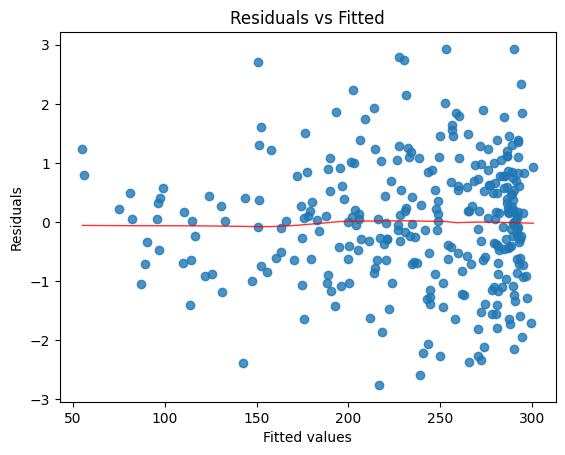

In [267]:
linear = plt.figure()
linear.axes[0] = sns.regplot(x=fit_val, y=resids,
                                scatter=True,
                                ci=False,
                                lowess=True,
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
linear.axes[0].set_title('Residuals vs Fitted')
linear.axes[0].set_xlabel('Fitted values')
linear.axes[0].set_ylabel('Residuals');
linear.show()

Na wykresie mówiącym o liniowości nie widać trendu. Dane układają się równomiernie po obu stronach linii, która leży horyzontalnie. Aby się upewnić można wykonać jeszcze Ramsey RESET test, którego hipoteza twierdzi, że forma funkcyjna modelu jest liniowa.

In [268]:
print("P-value testu: " + str(sm.stats.diagnostic.linear_reset(results, test_type='fitted').pvalue))

P-value testu: 0.5641113659267523


Hipoteza zerowa nie została odrzucona, więc można przyjąć, że model ma linową formę funkcyjną.

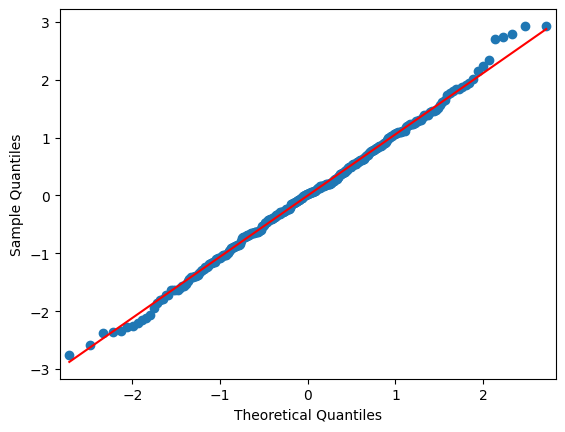

In [269]:
sm.qqplot(resids, line='s').show()

Na podstawie qq plotu widać, że residuua mają rozkład normalny. Można się jeszcze upewnić korzystając z testu Shapiro-Wilka.

In [270]:
print("P-value testu: " + str(scipy.stats.shapiro(resids).pvalue))

P-value testu: 0.7142630815505981


Hipoteza zerowa, jakoby rozkład był normalny nie została odrzucona, więc można przyjąć, że residuua mają rozkłąd normalny.

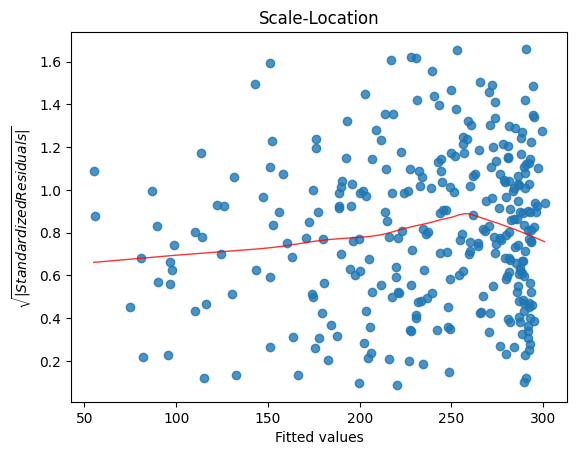

In [271]:
homoscedasticity = plt.figure()
sns.regplot(x=fit_val, y=np.sqrt(np.abs(results.get_influence().resid_studentized_internal)),
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
homoscedasticity.axes[0].set_title('Scale-Location')
homoscedasticity.axes[0].set_xlabel('Fitted values')
homoscedasticity.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
homoscedasticity.show()

Wykres mówiący o homoskedastyczności układa się w równomiernie po obu stronach linii, która jest w miarę horyzontalna (lekkie nachylenie nie powinno martwić).

In [272]:
auto = px.line(y=resids, labels={"y": "Residuals", "x": "Number of observation"}, title="Residuals vs number of observation")
auto.add_hline(y=0, line_color="black")
auto.show()

Powyższy wykres jeszcze mocniej potwierdza homoskedastyczność, ponieważ amplituda jest w miarę stała. Problem autokorelacjiteż prawdopodobnie już nie występuje, ponieważ wartości oscylują wokół linii zerowej.

In [273]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_model_2.columns
vif_data["VIF"] = [variance_inflation_factor(df_model_2.values, i) for i in range(len(df_model_2.columns))]
print(vif_data)

            feature         VIF
0             const  937.195473
1              waga    1.152084
2              wiek    1.172917
3          dzieci_1    2.369719
4          dzieci_2    2.248136
5          dzieci_3    2.030989
6          dzieci_4    1.706915
7          dzieci_5    1.272432
8          stosunek   11.161619
9  stosunek_squared   11.150073


Wartości VIF są w normie dla wszystkich zmiennych, prócz stosunku i stosunku_squared. Jednak nie oznacza, to rzeczywistego problemu z multikolinearnoscią, ponieważ sami celowo dodaliśmy te zmienne.

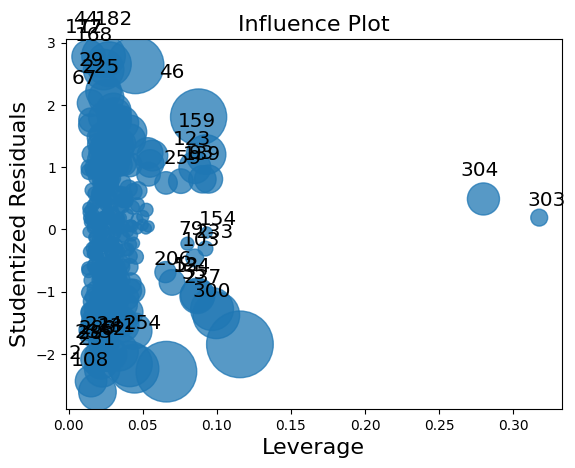

In [274]:
sm.graphics.influence_plot(results, criterion="cooks").show()

Influence plot wygląda dość dobrze. Wciąż wyróżniają się dwie obserwacje, 303 i 304. Mają one duży wpływ na nasz model, jednak nie mają one dużych residuów, więc nie trzeba ich usuwać.

Poprawiony model spełnia założenia KMRL!

## Interpretacja współczynników w nowym modelu

In [275]:
print("Współczynniki modelu:")
print(results.params)

Współczynniki modelu:
const               2.581221
waga                0.361864
wiek               -0.246314
dzieci_1            1.582439
dzieci_2            3.214134
dzieci_3            4.388132
dzieci_4            6.214900
dzieci_5            7.660623
stosunek            0.698977
stosunek_squared   -0.000449
dtype: float64


Nasz "najlepszy" model przewiduje wzrost kosztów wyżywiena miesięcznego o średnio 1.5 bajtalara za każde dziecko, które obywatel posiada. Widać, że jeśli ktoś ma jedno dziecko, to jego miesięczne wydatki żywieniowe na nie wynoszą 1.58, zaś jak ktoś ma na przykład trójkę to już wydaje na nie mniej więcej 4.38. Natomiast przewiduje też on 0.36 bajtlara za każdy kilogram, który wlicza się w wagę ciała obywatela. Mogło by się wydawać to dziwne, że posiadanie dziecka to koszt porównywalny do 4-5 kilogramów, ale nie można zapominać o tym, że na zmienne może wpływać wiele innych czynników, takich jak to, że badana próba ze społeczeństwa była w wieku, w którym większość dzieci mogły się już usamodzielnić, albo że partner wydaje pieniądze na wspólne wyżywienie w gospodarstwie. Stąd wyniki te nie powinny być brane, aż tak dosłownie.

## Charakterystyka osób należących do górnych 10% predykcji wydatków na żywność

In [276]:
df_opis = pd.read_csv('dane_projekt1.csv', sep = ";", index_col='id').sort_values('id')
df_model_2['predicted'] = results.predict()
top_indexes = df_model_2.nlargest(int(len(df_model_2.index) / 10), 'predicted').index
top = df_opis.loc[top_indexes]
print("Tabela statystyk 10% obywateli o największych wydatkach żywieniowych:")
print("---------------------------------------------------------------------------")
print(top.describe())

Tabela statystyk 10% obywateli o największych wydatkach żywieniowych:
---------------------------------------------------------------------------
            waga      wzrost       plec     dzieci       wiek       dochod  \
count  30.000000   30.000000  30.000000  30.000000  30.000000    30.000000   
mean   81.390000  174.529667   1.666667   2.766667  52.200000  1607.177000   
std     2.247217    5.990201   0.479463   1.381736   5.845128   978.272988   
min    77.560000  159.970000   1.000000   0.000000  42.000000   771.060000   
25%    80.187500  172.397500   1.000000   2.000000  47.250000   916.205000   
50%    81.035000  174.970000   2.000000   3.000000  53.500000  1110.285000   
75%    82.682500  178.092500   2.000000   4.000000  56.000000  2481.862500   
max    86.060000  183.290000   2.000000   5.000000  65.000000  3893.040000   

       oszczednosci    jednoos    miejsce  wydatki_zyw  
count     30.000000  30.000000  30.000000    30.000000  
mean     841.642000   0.366667   2.16

Część społeczeństwa wydająca najwięcej na jedzenie charakteryzuje się wiekiem średnim. Nie ma widocznej dominacji przedstawicieli którejkolwiek płci.

Widać duże odchylenie standardowe względem dochodu, co oznacza, że dochody 10% społeczeństwa wydającego najwięcej na wyżywienie wcale nie są na podobnym poziomie. Zobaczmy jak dane na temat dochodu będą wyglądały na wykresie:

In [277]:
px.histogram(top['dochod'], labels={'value': 'dochód', 'count': 'ilość obywateli'}, title="dochód obywateli").show()

Rzeczywiście widać duży rozstrzał dochodów wśród obywateli o największych wydatkach na wyżywienie. Większość z tych obywateli jednak nie posiada dużych dochodów.

### Przyjrzymy się części obserwowanej grupy o mniejszych dochodach

In [278]:
less = top[top['dochod'] <= 1500]

px.bar(less['jednoos'].value_counts(), labels={"jednoos": "status zamieszkania", "value": "ilość obywateli"}, title="Status zamieszkania (0 - Mieszka z kimś, 1 - Mieszka samemu)").show()
px.bar(less['dzieci'].value_counts(), labels={"dzieci": "liczba dzieci", "value": "ilość obywateli"}, title="Liczba dzieci").show()
px.bar(less['miejsce'].value_counts(), labels={"dzieci": "liczba dzieci", "value": "ilość obywateli"}, title="Liczba dzieci").show()

Widać, że osoby o mniejszych dochodach wydające dużo na wyżywienie nie mieszkają same, a potencjalnie jeszcze utrzymują rodzinę wielodzietną. Większość z tych rodzin mieszka w miejscowościach średnich lub większych.

### Przyjrzyjmy się pozostałym obywatlom, mającym większy dochód

In [279]:
more = top[top['dochod'] > 1500]


px.bar(more['jednoos'].value_counts(), labels={"jednoos": "status zamieszkania", "value": "ilość obywateli"}, title="Status zamieszkania (0 - Mieszka z kimś, 1 - Mieszka samemu)").show()
px.bar(more['dzieci'].value_counts(), labels={"dzieci": "liczba dzieci", "value": "ilość obywateli"}, title="Liczba dzieci").show()
px.bar(more['miejsce'].value_counts(), labels={"dzieci": "liczba dzieci", "value": "ilość obywateli"}, title="Liczba dzieci").show()

Wszystkie osoby wydające dużo na wyżywienie mające większe dochody, mieszkają same. Mają oni również dzieci, ale już z nimi nie mieszkają przez co bezpośrednio nie wydają pieniędzy na ich wyżywienie. Co do wielkości miejscowości, to nie widać szczególnych trendów.

Podsumowując, największe wydatki żywieniowe głównie posiadają obywatele z gospodarstw wieloosobowych oraz osoby o większych dochodach, które są w stanie sobie na nie pozwolić.